# Project 2: Neural Networks for Image Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#load data chunks and converts to numpy arrays
def load_pose_data():
    pose = np.array(loadmat('./data/pose.mat')['pose'])
    illum = np.array(loadmat('./data/illumination.mat')['illum'])
    return pose, illum

def make_pose_dataset(pose, illum, test_size = .3):
    pose_data = []
    pose_labels = []
    for subject in range(68):
        for img in range(13):
            pose_data.append(pose[:,:,img,subject])
            pose_labels.append(subject)
            
    pose_data = np.array(pose_data)
    pose_labels = np.transpose(np.array(pose_labels))
    
    X_train, X_test, y_train, y_test = train_test_split(pose_data, pose_labels, test_size=test_size, random_state=31, stratify=pose_labels)
    X_train, y_train = list(X_train), list(y_train)
    
    for subject in range(68):
        for img in range(21):
            image = illum[:,img,subject].reshape((40,48))
            image = np.flip(np.rot90(image))
            X_train.append(image)
            y_train.append(subject)
            
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    return X_train, X_test, y_train, y_test

### Networks
##### Below are functions to create the three neural networks architectures that I will be testing. The first is a very simple, shallow sequential NN, the second is a CNN, and the third is a deeper CNN.

In [4]:
#networks
def build_sequential(num_classes):
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_large_cnn(input_shape):
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(input_shape), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_big_pose(input_shape):
    # create model
    model = Sequential()
    model.add(Conv2D(48, (5, 5), input_shape=(input_shape), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(192, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25,restore_best_weights=True)

## POSE Dataset
##### I will first test these architectures on the POSE data from project 1.

In [5]:
#load pose data
pose, illum = load_pose_data()
X_train, X_test, y_train, y_test = make_pose_dataset(pose, illum)

#expand dimension to include number channels
X_train = X_train.reshape((X_train.shape[0], 48, 40, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 48, 40, 1)).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
num_pixels = X_train.shape[1] * X_train.shape[2]

#flattened versions of data for sequentail model
X_train_flat = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test_flat = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

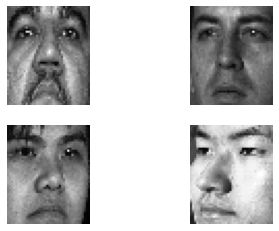

In [6]:
# view pose data
imgs = X_train[:4].reshape((4,48,40))
plt.subplot(221)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(222)
plt.imshow(imgs[1], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(223)
plt.imshow(imgs[2], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(224)
plt.imshow(imgs[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.axis('off')
plt.show()

### Simple Sequential Model

In [7]:
# build the model
pose_sequential = build_sequential(num_classes)
pose_sequential.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1920)              3688320   
_________________________________________________________________
dense_1 (Dense)              (None, 68)                130628    
Total params: 3,818,948
Trainable params: 3,818,948
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Fit the model
pose_seq_history = pose_sequential.fit(X_train_flat, y_train, validation_data=(X_test_flat, y_test), 
                                       epochs=125, batch_size=100, verbose=2, callbacks=[early_stop])
# Final evaluation of the model
pose_seq_scores = pose_sequential.evaluate(X_test_flat, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-pose_seq_scores[1]*100))

Epoch 1/125
21/21 - 0s - loss: 5.9425 - accuracy: 0.0367 - val_loss: 5.4444 - val_accuracy: 0.0451
Epoch 2/125
21/21 - 0s - loss: 4.0250 - accuracy: 0.1667 - val_loss: 3.8710 - val_accuracy: 0.1203
Epoch 3/125
21/21 - 0s - loss: 2.9349 - accuracy: 0.3910 - val_loss: 3.3782 - val_accuracy: 0.2143
Epoch 4/125
21/21 - 0s - loss: 2.3866 - accuracy: 0.5210 - val_loss: 3.0369 - val_accuracy: 0.2556
Epoch 5/125
21/21 - 0s - loss: 1.8859 - accuracy: 0.6598 - val_loss: 2.6540 - val_accuracy: 0.3045
Epoch 6/125
21/21 - 0s - loss: 1.4826 - accuracy: 0.7625 - val_loss: 2.4796 - val_accuracy: 0.4211
Epoch 7/125
21/21 - 0s - loss: 1.2391 - accuracy: 0.8133 - val_loss: 2.1570 - val_accuracy: 0.4925
Epoch 8/125
21/21 - 0s - loss: 1.0068 - accuracy: 0.8504 - val_loss: 2.1829 - val_accuracy: 0.4436
Epoch 9/125
21/21 - 0s - loss: 0.8546 - accuracy: 0.8675 - val_loss: 1.9738 - val_accuracy: 0.5263
Epoch 10/125
21/21 - 0s - loss: 0.6727 - accuracy: 0.9110 - val_loss: 1.8861 - val_accuracy: 0.5714
Epoch 11/

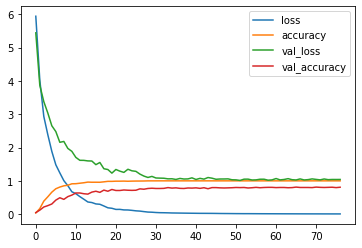

In [9]:
frame = pd.DataFrame(pose_seq_history.history)
frame.plot()

### Convolutional Neural Net

In [10]:
input_shape = (X_train.shape[1],X_train.shape[2],1)

In [11]:
# build the model
pose_cnn = build_cnn(input_shape)
pose_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 36, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 18, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12672)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1622144   
_________________________________________________________________
dense_3 (Dense)              (None, 68)                8772      
Total params: 1,631,748
Trainable params: 1,631,748
Non-trainable params: 0
____________________________________________

In [12]:
# Fit the model
pose_cnn_history = pose_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), 
                                epochs=150, batch_size=100, callbacks=[early_stop])
# Final evaluation of the model
pose_cnn_scores = pose_cnn.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-pose_cnn_scores[1]*100))

Epoch 1/150
21/21 [==============================] - 1s 53ms/step - loss: 4.2318 - accuracy: 0.0220 - val_loss: 4.1630 - val_accuracy: 0.0602
Epoch 2/150
21/21 [==============================] - 1s 52ms/step - loss: 4.0702 - accuracy: 0.0699 - val_loss: 3.9810 - val_accuracy: 0.1015
Epoch 3/150
21/21 [==============================] - 1s 53ms/step - loss: 3.7041 - accuracy: 0.1735 - val_loss: 3.6077 - val_accuracy: 0.1429
Epoch 4/150
21/21 [==============================] - 1s 50ms/step - loss: 3.0215 - accuracy: 0.3519 - val_loss: 3.0151 - val_accuracy: 0.2820
Epoch 5/150
21/21 [==============================] - 1s 48ms/step - loss: 2.2591 - accuracy: 0.5269 - val_loss: 2.5184 - val_accuracy: 0.3158
Epoch 6/150
21/21 [==============================] - 1s 47ms/step - loss: 1.6108 - accuracy: 0.7082 - val_loss: 2.2331 - val_accuracy: 0.3797
Epoch 7/150
21/21 [==============================] - 1s 48ms/step - loss: 1.1457 - accuracy: 0.7869 - val_loss: 2.0101 - val_accuracy: 0.4624
Epoch 

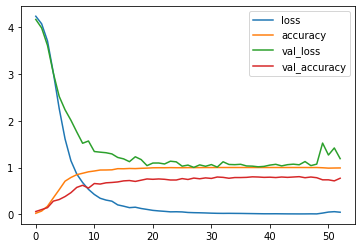

In [13]:
pd.DataFrame(pose_cnn_history.history).plot()

### Large Convolutional Neural Net

In [21]:
# build the model
big_pose_cnn = build_big_pose(input_shape)
big_pose_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 44, 36, 48)        1248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 18, 48)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 16, 96)        41568     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 8, 96)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 6, 192)         166080    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 3, 192)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 3, 192)        

In [22]:
# Fit the model
big_pose_cnn_history = big_pose_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100, callbacks=[early_stop])
# Final evaluation of the model
big_pose_cnn_scores = big_pose_cnn.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-big_pose_cnn_scores[1]*100))

Epoch 1/80
103/103 [==============================] - 3s 33ms/step - loss: 4.2221 - accuracy: 0.0073 - val_loss: 4.2196 - val_accuracy: 0.0150
Epoch 2/80
103/103 [==============================] - 3s 32ms/step - loss: 4.2207 - accuracy: 0.0132 - val_loss: 4.2196 - val_accuracy: 0.0113
Epoch 3/80
103/103 [==============================] - 3s 32ms/step - loss: 4.2203 - accuracy: 0.0112 - val_loss: 4.2196 - val_accuracy: 0.0113
Epoch 4/80
103/103 [==============================] - 3s 33ms/step - loss: 4.2212 - accuracy: 0.0176 - val_loss: 4.2182 - val_accuracy: 0.0188
Epoch 5/80
103/103 [==============================] - 3s 33ms/step - loss: 4.1953 - accuracy: 0.0210 - val_loss: 4.0701 - val_accuracy: 0.0338
Epoch 6/80
103/103 [==============================] - 3s 33ms/step - loss: 4.0914 - accuracy: 0.0279 - val_loss: 3.9320 - val_accuracy: 0.0301
Epoch 7/80
103/103 [==============================] - 3s 33ms/step - loss: 3.8402 - accuracy: 0.0440 - val_loss: 3.6497 - val_accuracy: 0.0451

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(dict(big_pose_cnn_history.history)).plot()

In [ ]:
big_pose_cnn.evaluate(X_test,y_test)

## MNIST

In [ ]:
#load mnist data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# view mnist data
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

#### Data Preprocessing

In [ ]:
#expand dimension to include number channels
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
num_pixels = X_train.shape[1] * X_train.shape[2]

#flattened versions of data for sequentail model
X_train_flat = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test_flat = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

### Simple Sequential Network

In [ ]:
# build the model
mnist_sequential = build_sequential(num_classes)
# Fit the model
mnist_sequential.fit(X_train_flat, y_train, validation_data=(X_test_flat, y_test), epochs=20, batch_size=200, verbose=2, callbacks=[early_stop])
# Final evaluation of the model
scores = mnist_sequential.evaluate(X_test_flat, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

### Convolutional Neural Net

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],1)

In [ ]:
# build the model
mnist_cnn = build_cnn(input_shape)
# Fit the model
mnist_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=200, callbacks =[earyl_stop])
# Final evaluation of the model
scores = mnist_cnn.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

### Large Convolutional Neural Net

In [ ]:
# build the model
mnist_big_cnn = build_large_cnn(input_shape)
# Fit the model
mnist_big_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, callbacks =[early_stop])
# Final evaluation of the model
scores = mnist_large_cnn.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))